<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка,-предобработка-и-анализ-данных" data-toc-modified-id="Подготовка,-предобработка-и-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка, предобработка и анализ данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка, предобработка и анализ данных

In [2]:
!pip install scikit-learn==1.1.3 -q
!pip install catboost -q
!pip install spacy -q
!spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import spacy
from pymystem3 import Mystem
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.pipeline import (Pipeline, make_pipeline)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords

RANDOM_STATE = 42

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
wikishop = pd.read_csv('/datasets/toxic_comments.csv')

In [5]:
def info_about(data):
    display(data.head(10))
    display(data.info())
    display(data.describe())
    display(data.duplicated().sum())
    display(data.isna().sum())
    display(data.corr())
    data.hist(figsize=(12, 12))

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


0

Unnamed: 0    0
text          0
toxic         0
dtype: int64

,Unnamed: 0,toxic
Unnamed: 0,1.000000,-0.002756
toxic,-0.002756,1.000000


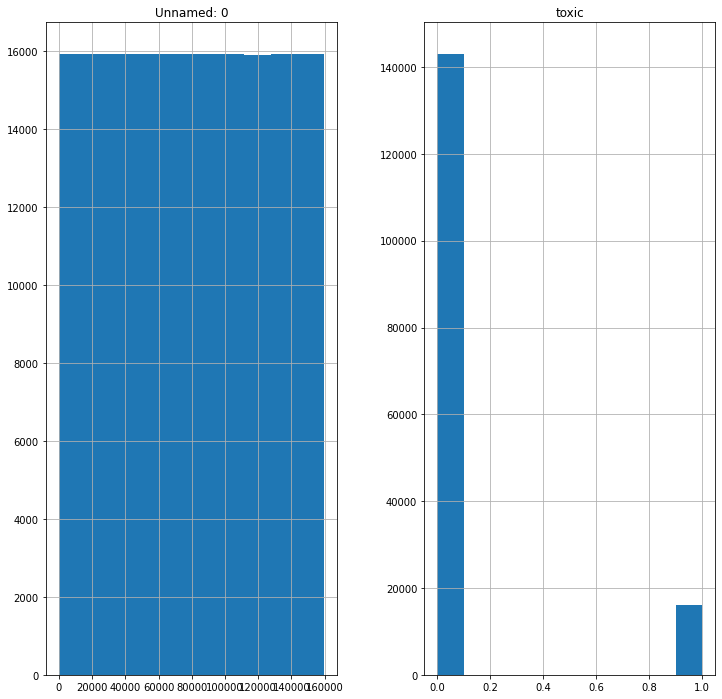

In [6]:
info_about(wikishop)

In [7]:
#Видим, что столбец Unnamed дублирует столбец с индексами, уберем его
wikishop = wikishop.drop('Unnamed: 0', axis=1)
wikishop.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


**ПРОМЕЖУТОЧНЫЙ ВЫВОД:** Тип данных в столбцах верный. Пропусков и дубликатов нет, названия столбцов соответствуют "змеиному" регистру. Видим что текст в столбце *text* в разном регистре, а также имеются различные символы - разберемся с этим дальше. 

In [8]:
#Объявим лемматизатор
nlp = spacy.load("en_core_web_sm")

In [9]:
def clear_text(text):
    #Текст в нижний регистр
    text = text.lower()
    #Удаление всех символов, кроме английских букв и пробелов
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    #Удаление лишних пробелов
    text = " ".join(text.split())
    return text

In [10]:
lemm = []

for i in tqdm(range(len(wikishop))):
    tokens = clear_text(wikishop.text[i])
    tokens = nlp(tokens)
    lemm.append(" ".join([token.lemma_ for token in tokens]))

wikishop['lemm_text'] =  lemm
wikishop.head()

100%|██████████| 159292/159292 [34:40<00:00, 76.55it/s] 


,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


**ПРОМЕЖУТОЧНЫЙ ВЫВОД:** Текст приведен к нижнему регистру, избавились от ненужных символов, провели лемматизацию. Добавили столбец с лемматизированным текстом в датасет.

In [11]:
#Взглянем на уникальные значения нашего целевого признака
wikishop['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

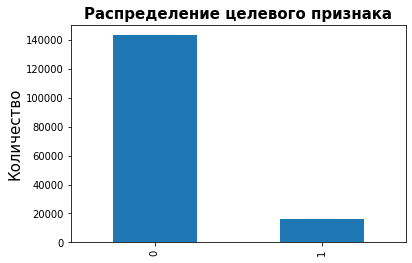

In [12]:
#Посмотрим на распределение 
wikishop['toxic'].value_counts().plot.bar()
plt.title('Распределение целевого признака', fontsize = 15, fontweight='bold')
plt.ylabel('Количество', fontsize = 15)
plt.show()

**ВЫВОД:** 
- Тип данных в столбцах верный. Пропусков и дубликатов нет, названия столбцов соответствуют "змеиному" регистру;

- Комментарии написаны на английском языке;

- Текст приведен к нижнему регистру, избавились от ненужных символов, провели лемматизацию. Добавили столбец с лемматизированным текстом в датасет;

- Целевой признак *toxic* содержит два значения - 0 и 1, обнаружили дисбаланс классов.

## Обучение

In [13]:
X = wikishop['lemm_text']
y = wikishop['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y) 

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127433,), (31859,), (127433,), (31859,))

In [14]:
#Найдём стоп-слова
stopwords = list(nltk_stopwords.words('english'))

In [15]:
#Создадим счётчик и передадим в него список стоп-слов
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [16]:
#TF-IDF
train_tf_idf = count_tf_idf.fit_transform(X_train)
test_tf_idf = count_tf_idf.transform(X_test)

In [17]:
display(train_tf_idf.shape, 
        test_tf_idf.shape)

(127433, 132365)

(31859, 132365)

In [18]:
#Функция grid для подбора параметров
def grid(model, params):
    pipeline = Pipeline([('model', model)])    
    grid = GridSearchCV(
        pipeline, 
        cv = 5, 
        n_jobs = -1, 
        param_grid = params ,
        scoring = 'f1', 
        verbose = False)
    grid.fit(train_tf_idf, y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid   

In [21]:
#LogisticRegression()
log_reg = grid(LogisticRegression(random_state=RANDOM_STATE), {"model__C":range(5,15), "model__penalty":["l1", "l2"]})

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучший результат: 0.7723446727352241
Лучшие параметры: {'model__C': 13, 'model__penalty': 'l2'}


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
#DecisionTreeClassifier
dec_tree = grid(DecisionTreeClassifier(), {'model__class_weight':['balanced'], 
                                           'model__max_depth':range(1,10), 
                                           'model__max_features': range(1,10)})

Лучший результат: 0.1869607014433318
Лучшие параметры: {'model__class_weight': 'balanced', 'model__max_depth': 5, 'model__max_features': 7}


In [25]:
#CatBoostClassifier
cat_boost = grid(CatBoostClassifier(logging_level='Silent'), {'model__depth': [6],
                 'model__learning_rate' : [0.1],
                  'model__iterations' : [100]})

Лучший результат: 0.6538555436655619
Лучшие параметры: {'model__depth': 6, 'model__iterations': 100, 'model__learning_rate': 0.1}


In [26]:
#Оформим результаты
results = pd.DataFrame({'Модель': ['LogisticRegression', 'DecisionTreeClassifier', 'CatBoostClassifier'],
                        'f1_score': [log_reg.best_score_, dec_tree.best_score_, cat_boost.best_score_]})
display(results.sort_values(by='f1_score', ascending=False))

,Модель,f1_score
0,LogisticRegression,0.772345
2,CatBoostClassifier,0.653856
1,DecisionTreeClassifier,0.185853


LogisticRegression() проявила себя лучше всех. Остальные показали результат даже ниже необходимого по условию задачи.

In [27]:
#Проверка лучшей модели на тестовых данных
y_pred = log_reg.predict(test_tf_idf)
f1_score_pred = f1_score(y_test, y_pred)
f1_score_pred

0.7831571769519263

## Выводы

В нашем распоряжении был набор данных с разметкой о токсичности правок.
Цель нашего проекта состояла в построении модели со значением метрики качества F1 не меньше 0.75.

Вот что было изучено и сделано:

- Тип данных в столбцах верный. Пропусков и дубликатов нет, названия столбцов соответствуют "змеиному" регистру;

- Комментарии написаны на английском языке;

- Текст приведен к нижнему регистру, избавились от ненужных символов, провели лемматизацию. Добавили столбец с лемматизированным текстом в датасет;

- Целевой признак *toxic* содержит два значения - 0 и 1, обнаружили дисбаланс классов.

Обучили такие модели как LogisticRegression(), DecisionTreeClassifier, CatBoostClassifier.

Получили следующие значения f1_score:

- LogisticRegression - 0.7723446727352241

- DecisionTreeClassifier - 0.18585251861533533

- CatBoostClassifier - 0.6538555436655619

На тестовых данных LogisticRegression показала значение метрики F1 равное 0.7831571769519263.

**Рекомендации заказчику:** для классификации комментариев на позитивные и негативные использование модели LogisticRegression будет самым оптимальным решением.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны